In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
from matplotlib import cm
from matplotlib import colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from dlt.model import PDFmodel
from dlt.distribution import Distribution

In [2]:
from dlt import data
from pathlib import Path
import importlib.resources as pkg_resources

data_path = Path(pkg_resources.files(data) / "BCDMS_data")
fk_grid = np.load(data_path / 'fk_grid.npy')
data = np.load(data_path / 'data.npy')
FK_original = np.load(data_path / 'FK.npy')
f_bcdms = np.load(data_path / 'f_bcdms.npy')
Cy = np.load(data_path / 'Cy.npy')

In [3]:
def plot_matrix(matrix, x_labels=None, x_ticklocks=None, fontsize=10, pad=10, y_labels=None, y_ticklocks=None, **kwargs):
  # Show the FK tables
  if not isinstance(matrix, np.ndarray):
    matrix = np.array(matrix)

  fig, ax = plt.subplots(**kwargs)
  matrixplot = ax.matshow(
      matrix,
      cmap=cm.Spectral_r,
      norm=mcolors.SymLogNorm(
          linthresh=0.00001, linscale=1, vmin=matrix.min(), vmax=matrix.max()
      ),
  )
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.5)
  cbar = fig.colorbar(matrixplot, cax=cax)
  cbar.ax.tick_params(labelsize=fontsize)

  if x_ticklocks is not None:
    ax.set_xticks(x_ticklocks)
  if x_labels is not None:
    _ = ax.set_xticklabels(x_labels, rotation=20, ha="left", fontsize=fontsize)

  if y_labels is not None and y_ticklocks is not None:
    ax.set_yticks(y_ticklocks)
    _ = ax.set_yticklabels(y_labels, rotation=20, ha="left", fontsize=fontsize)
    ax.tick_params(axis='y', pad=pad)

  fig.tight_layout()
  return fig, ax

# Monkey patch to PDFmodel

In [4]:
import tensorflow.keras as keras
import tensorflow as tf

def get_preactivation(self, layer_idx, input_data):
    """
    Extract pre-activation values for a specific layer given input data
    
    Args:
        layer_idx (int): Index of the layer (0-indexed)
        input_data: Input data to the model
    """
    keras_model = self.model
    
    if layer_idx == 0:
        # For first layer, pre-activations are the inputs
        return input_data
    
    # Create a function that outputs the pre-activation (input to the layer)
    get_preact_fn = keras.Function(
        [keras_model.inputs[0]],
        [keras_model.layers[layer_idx].input]
    )
    
    # Get pre-activations
    return get_preact_fn([input_data])[0]

def compute_preactivation_product(self, layer_idx, input_data=None):
    """
    Compute the product of pre-activations:
    φ_{i1,α1}^(l) * φ_{i2,α2}^(l)
    """
    if input_data is None:
        input_data = self.inputs

    # Add batch dimension if missing
    if len(np.array(input_data).shape) == 2:  # If shape is (50, 1)
        input_data = np.expand_dims(input_data, axis=0)  # Make it (1, 50, 1)
    
    preactivations = self.get_preactivation(layer_idx, input_data)
    
    phi_alpha1_i1 = preactivations[0, :, :] # Shape: [data, neuron]
    phi_alpha2_i2 = preactivations[0, :, :] # Shape: [data, neuron]

    # Use tf.matmul with reshaping for the outer product
    # First reshape to column and row vectors
    # phi1_column = tf.reshape(phi_i1_alpha1, [-1, 1])  # Shape: [batch_size, 1]
    # phi2_row = tf.reshape(phi_i2_alpha2, [1, -1])     # Shape: [1, batch_size]
    
    # Compute outer product
    #tensor_product = tf.matmul(phi1_column, phi2_row)
    tensor_product = tf.einsum('ai,bj->abij', phi_alpha1_i1, phi_alpha2_i2)
    
    return tensor_product

# Monkey patch the PDFmodel class
PDFmodel.get_preactivation = get_preactivation
PDFmodel.compute_preactivation_product = compute_preactivation_product

# Integrating the gradient flow

In [5]:
# Generating and ensemble of models
replicas = 100
seed = 1423413
models = []
phi_a1a2_phi_i1i2_dist = Distribution("phi_a1a2_phi_i1i2_dist")
k1_norm_i1i2_dist = Distribution("k1_norm_i1i2")
for rep in range(replicas):
  model = PDFmodel(
          dense_layer='Dense',
          input=fk_grid,
          outputs=1,
          architecture=[25, 20],
          activations=['tanh', 'tanh'],
          kernel_initializer='GlorotNormal',
          user_ki_args=None,
          seed=seed + rep,
          init_bias=True)
  phi_a1a2_phi_i1i2 = model.compute_preactivation_product(1)
  phi_a1a2_phi_i1i2_dist.add(phi_a1a2_phi_i1i2)
  k1_norm_i1i2 = np.linalg.norm(phi_a1a2_phi_i1i2, axis=(0, 1))
  k1_norm_i1i2_dist.add(k1_norm_i1i2)


(<Figure size 640x480 with 2 Axes>, <Axes: >)

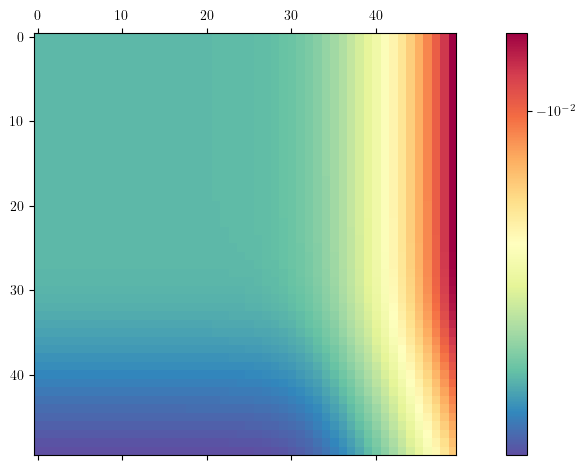

In [6]:
K_a1a2_i1i2 = phi_a1a2_phi_i1i2_dist.get_mean(axis=0)
plot_matrix(K_a1a2_i1i2[:,:,0,20])

(<Figure size 1000x1000 with 2 Axes>, <Axes: >)

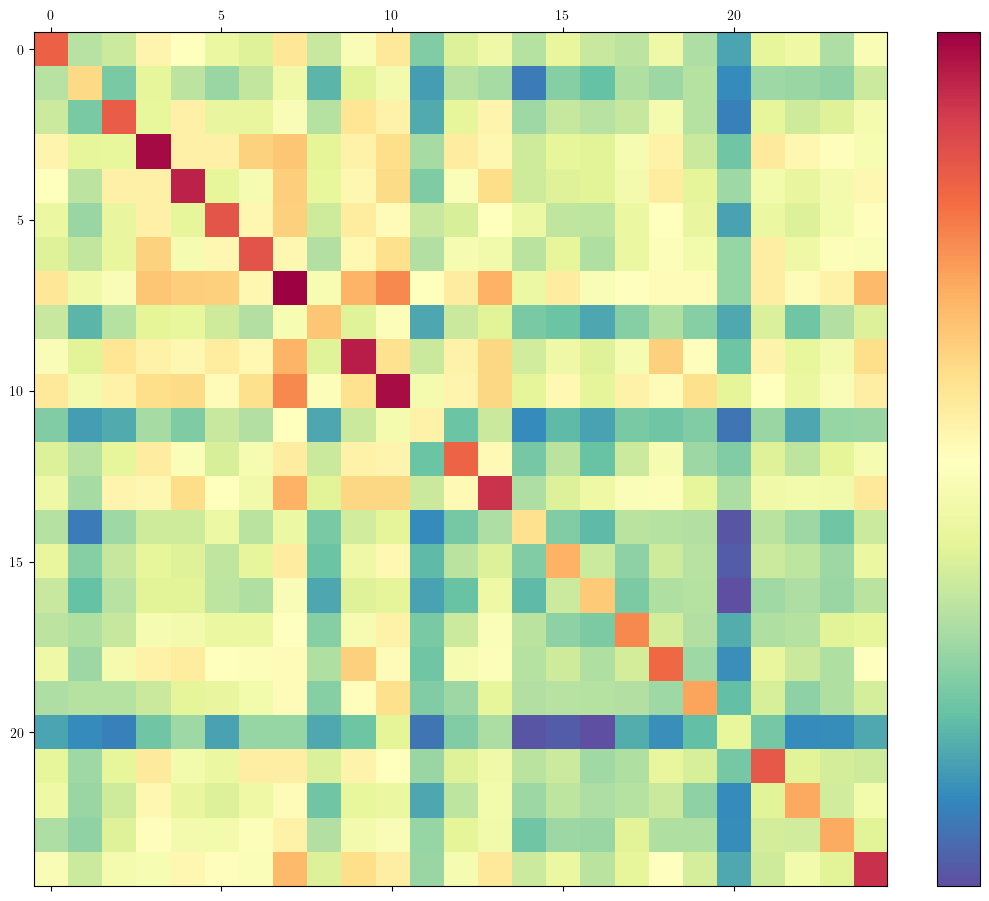

In [36]:
mean = k1_norm_i1i2_dist.get_mean()
plot_matrix(mean, figsize=(10, 10), fontsize=10, pad=10)

# Recursion relation for the kernel

1.14456182484638e-89


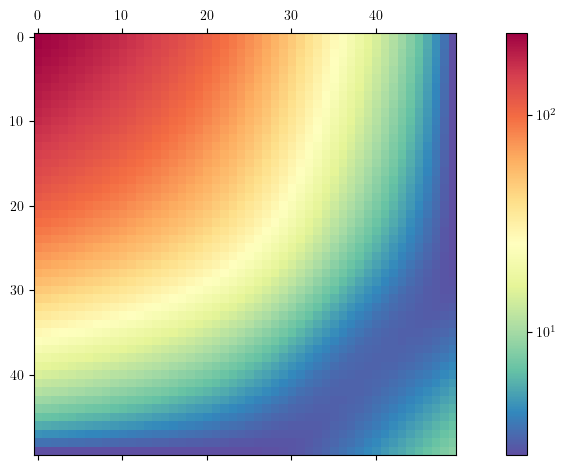

In [80]:
X = np.array([[x, np.log(x), np.exp(x)] for x in fk_grid])
XX = np.einsum('aj,bj->ab', X, X) + np.identity(X.shape[0]) * 1e-2
plot_matrix(XX)
print(np.linalg.det(XX))

In [82]:
np.logspace(-5, -4, num=3)

array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04])

In [84]:
np.log10(2e-7)

-6.698970004336019

In [81]:
fk_grid

array([2.00000000e-07, 3.03430477e-07, 4.60350147e-07, 6.98420853e-07,
       1.05960950e-06, 1.60758550e-06, 2.43894329e-06, 3.70022721e-06,
       5.61375772e-06, 8.51680668e-06, 1.29210157e-05, 1.96025050e-05,
       2.97384954e-05, 4.51143839e-05, 6.84374492e-05, 1.03811730e-04,
       1.57456056e-04, 2.38787829e-04, 3.62054496e-04, 5.48779532e-04,
       8.31406884e-04, 1.25867971e-03, 1.90346340e-03, 2.87386758e-03,
       4.32850064e-03, 6.49620619e-03, 9.69915957e-03, 1.43750686e-02,
       2.10891867e-02, 3.05215840e-02, 4.34149174e-02, 6.04800288e-02,
       8.22812213e-02, 1.09143757e-01, 1.41120806e-01, 1.78025660e-01,
       2.19504127e-01, 2.65113704e-01, 3.14387401e-01, 3.66875319e-01,
       4.22166775e-01, 4.79898903e-01, 5.39757234e-01, 6.01472198e-01,
       6.64813948e-01, 7.29586844e-01, 7.95624252e-01, 8.62783932e-01,
       9.30944081e-01, 1.00000000e+00])

2.0622665437110902e-190


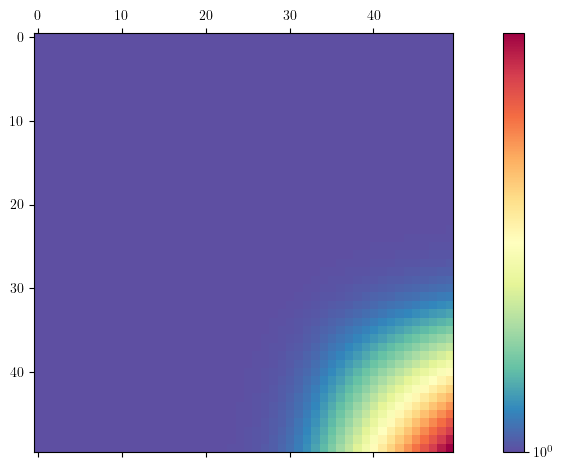

In [51]:
XX = np.outer(fk_grid, fk_grid)
delta = 1.e-4
K_1 = np.ones_like(XX) + XX + delta * np.eye(len(fk_grid))
plot_matrix(K_1)
print(np.linalg.det(K_1))

In [56]:
class MultivariateGaussian:
    def __init__(self, mean, covariance):
        """
        Initialize the multivariate Gaussian distribution.

        Args:
            mean (np.ndarray): Mean vector of the distribution.
            covariance (np.ndarray): Covariance matrix of the distribution.
        """
        self.mean = mean
        self.covariance = covariance
        self.dim = mean.shape[0]

    def pdf(self, x):
        """
        Compute the probability density function (PDF) at point x.

        Args:
            x (np.ndarray): Point at which to evaluate the PDF.

        Returns:
            float: The value of the PDF at point x.
        """
        diff = x - self.mean
        exponent = -0.5 * (diff.T @ np.linalg.inv(self.covariance) @ diff)
        normalization = 1 / np.sqrt((2 * np.pi) ** self.dim * np.linalg.det(self.covariance))
        return normalization * np.exp(exponent)


    def sample(self, num_samples):
        """
        Generate samples from the multivariate Gaussian distribution.

        Args:
            num_samples (int): Number of samples to generate.

        Returns:
            np.ndarray: Samples drawn from the distribution.
        """
        return np.random.multivariate_normal(self.mean, self.covariance, num_samples)

In [57]:
def compute_expectation_value(func, dist, lower_limit=None, upper_limit=None):
    """
    Compute the expectation value of a function with respect to a multivariate Gaussian distribution.
    """
    from scipy.integrate import nquad
    
    # Define the integrand
    def integrand(*args):
        point = np.array(args)
        return func(point) * dist.pdf(point)
    
    # Set integration limits
    if lower_limit is None:
        lower_limit = [-1.e-8] * dist.dim
    if upper_limit is None:
        upper_limit = [1.e-8] * dist.dim
    
    # Create ranges for nquad - must be a list of (lower, upper) tuples
    ranges = [(lower_limit[i], upper_limit[i]) for i in range(dist.dim)]
    
    # Perform the integration
    result, error = nquad(integrand, ranges)
    
    return result

In [17]:
def second_moment(x):
    return np.outer(x,x)

def first_moment(x):
    return x

# Create a multivariate Gaussian distribution
mvg = MultivariateGaussian(np.zeros(K_1.shape[0]), K_1)

In [58]:
def improved_monte_carlo(func, dist, num_samples=10000, batch_size=1000):
    """
    Monte Carlo with error estimation via batching
    """
    batch_results = []
    for _ in range(num_samples // batch_size):
        samples = dist.sample(batch_size)
        batch_results.append(np.mean([func(sample) for sample in samples], axis=0))
    
    return np.mean(batch_results, axis=0), np.std(batch_results, axis=0)/np.sqrt(len(batch_results))

In [22]:
first_moment_mean, first_moment_std = improved_monte_carlo(first_moment, mvg, num_samples=10000000, batch_size=10000)

In [59]:
second_moment_mean, second_moment_std = improved_monte_carlo(second_moment, mvg, num_samples=10000000, batch_size=1000)

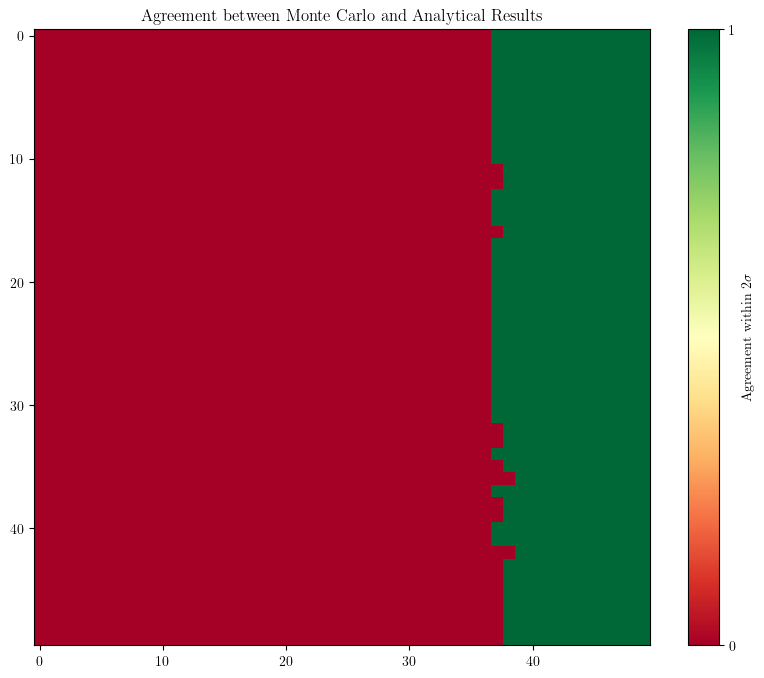

Agreement percentage: 25.24% of elements agree within 2σ


In [60]:
# Create agreement mask (True where difference is less than 2 standard deviations)
agreement_mask = np.abs(second_moment_mean - K_1) <= 2*first_moment_std

# Plot the boolean matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(agreement_mask, cmap='RdYlGn', interpolation='none')
plt.colorbar(im, ax=ax, ticks=[0, 1], label=r'$\textrm{Agreement within } 2\sigma$')
plt.title(r'$\textrm{Agreement between Monte Carlo and Analytical Results}$')
plt.show()

# Print percentage of elements that agree within uncertainties
agreement_percentage = 100 * np.sum(agreement_mask) / agreement_mask.size
print(f"Agreement percentage: {agreement_percentage:.2f}% of elements agree within 2σ")